[*********************100%***********************]  5 of 5 completed

Fetching stock data...
Fetching stock data for: ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'SPY']
Data fetched successfully!
Data saved to data/stock_data.csv
Ticker            AAPL       GOOGL        MSFT         SPY        TSLA
Date                                                                  
2024-01-02  184.734970  137.670929  368.117249  466.663971  248.419998
2024-01-03  183.351746  138.418213  367.849243  462.852814  238.449997
2024-01-04  181.023178  135.897369  365.208984  461.361969  237.929993
2024-01-05  180.296707  135.239731  365.020416  461.993866  237.490005
2024-01-08  184.655365  138.338501  371.908905  468.589264  240.449997

Creating Portfolio...



[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  3 of 3 completed


       Allocation %
QQQ            20.0
VOO            20.0
AGG            12.5
BND            12.5
GOOGL          12.5
TSLA           12.5
VLO             5.0
CVX             5.0

Running Monte Carlo Simulation on Entire Portfolio...


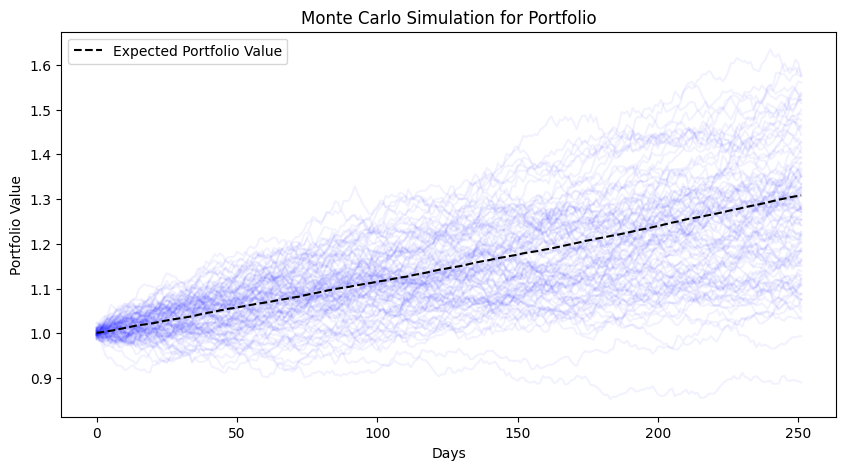


Evaluating Individual Stock Risks...
        Volatility  Sharpe Ratio  Max Drawdown
Ticker                                        
AAPL      0.224197      1.384991     -0.153548
GOOGL     0.280777      1.207664     -0.221376
MSFT      0.199495      0.681509     -0.154868
SPY       0.125770      1.723391     -0.084056
TSLA      0.636218      1.046204     -0.409233

Evaluating Overall Portfolio Risk...
           Volatility  Sharpe Ratio  Max Drawdown
Portfolio    0.161318      1.566534           0.0

Performing Threshold-Based Risk Assessment...

Risk Assessment Based on User Profile:
              Assessment
Volatility    Acceptable
Sharpe Ratio        Good
Max Drawdown  Acceptable

Suggesting Portfolio Adjustments for medium risk level...
{'AAPL': 'Portfolio is well-balanced, consider minor optimizations.', 'GOOGL': 'Portfolio is well-balanced, consider minor optimizations.', 'MSFT': 'Portfolio is well-balanced, consider minor optimizations.', 'SPY': 'Portfolio is well-balanced, cons

In [5]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure Jupyter Notebook can find project modules
sys.path.append(os.path.abspath(".."))

from app.data_fetch import fetch_stock_data
from app.portfolio_creation import create_portfolio
from app.simulation import monte_carlo_simulation
from app.risk_analysis import evaluate_portfolio_risk, suggest_portfolio_adjustments

# Step 1: Fetch Stock Data
print("Fetching stock data...")
tickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "SPY"]
stock_data = fetch_stock_data(tickers, start_date="2024-01-01")
print(stock_data.head())

# Step 2: Create Portfolio
print("\nCreating Portfolio...")
risk_level = "medium"  # Adjust as needed
portfolio = create_portfolio(risk_level=risk_level)
print(pd.DataFrame.from_dict(portfolio, orient="index", columns=["Allocation %"]) * 100)

# Step 3: Monte Carlo Simulation on Portfolio
print("\nRunning Monte Carlo Simulation on Entire Portfolio...")
portfolio_weights = np.array(list(portfolio.values()))
portfolio_returns = stock_data.pct_change().dropna()

# Ensure portfolio weights match stock data columns
portfolio_weights = portfolio_weights[:len(portfolio_returns.columns)]

# Generate simulations
num_simulations = 1000
time_horizon = 252
simulated_portfolio = np.zeros((num_simulations, time_horizon))

for i in range(num_simulations):
    simulated_returns = np.random.normal(portfolio_returns.mean().values, portfolio_returns.std().values, (time_horizon, len(portfolio_weights)))
    cumulative_returns = (1 + (simulated_returns @ portfolio_weights)).cumprod(axis=0)
    simulated_portfolio[i, :] = cumulative_returns

# Step 4: Plot Simulation for Entire Portfolio
plt.figure(figsize=(10, 5))
for sim in simulated_portfolio[:100]:
    plt.plot(sim, color="blue", alpha=0.05)
plt.plot(np.mean(simulated_portfolio, axis=0), color="black", linestyle="dashed", label="Expected Portfolio Value")
plt.title("Monte Carlo Simulation for Portfolio")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

# Step 5: Individual Stock Risk Analysis
print("\nEvaluating Individual Stock Risks...")
risk_metrics_individual = evaluate_portfolio_risk(stock_data)
print(risk_metrics_individual)

# Step 6: Portfolio-Level Risk Analysis
print("\nEvaluating Overall Portfolio Risk...")
portfolio_daily_returns = (portfolio_returns @ portfolio_weights)
portfolio_volatility = np.std(portfolio_daily_returns) * np.sqrt(252)
portfolio_sharpe_ratio = (np.mean(portfolio_daily_returns) * 252 - 0.02) / portfolio_volatility
portfolio_max_drawdown = (1 + portfolio_daily_returns).cumprod().cummax() - (1 + portfolio_daily_returns).cumprod()
portfolio_max_drawdown = portfolio_max_drawdown.min()

portfolio_risk_metrics = pd.DataFrame({
    "Volatility": [portfolio_volatility],
    "Sharpe Ratio": [portfolio_sharpe_ratio],
    "Max Drawdown": [portfolio_max_drawdown]
}, index=["Portfolio"])

print(portfolio_risk_metrics)

# Step 7: Threshold-Based Risk Assessment
print("\nPerforming Threshold-Based Risk Assessment...")
risk_thresholds = {
    "low": {"volatility": 0.15, "sharpe": 1.0, "drawdown": -0.10},
    "medium": {"volatility": 0.25, "sharpe": 0.5, "drawdown": -0.20},
    "high": {"volatility": 0.40, "sharpe": 0.2, "drawdown": -0.30}
}

threshold = risk_thresholds[risk_level]

risk_assessment = {
    "Volatility": "Acceptable" if portfolio_volatility <= threshold["volatility"] else "High Risk",
    "Sharpe Ratio": "Good" if portfolio_sharpe_ratio >= threshold["sharpe"] else "Needs Improvement",
    "Max Drawdown": "Acceptable" if portfolio_max_drawdown >= threshold["drawdown"] else "Too Risky"
}

print("\nRisk Assessment Based on User Profile:")
print(pd.DataFrame.from_dict(risk_assessment, orient="index", columns=["Assessment"]))

# Step 8: Portfolio Adjustments
print(f"\nSuggesting Portfolio Adjustments for {risk_level} risk level...")
adjustments = suggest_portfolio_adjustments(risk_metrics_individual, risk_level)
print(adjustments)